In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.gridspec as gridspec
import pymc as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pylab as pl
import scipy as sp
import pymc.graph
from graphviz import Digraph
import pydot
from IPython.display import Image
import pandas as pd
import seaborn as sns

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
def mcmc_to_dataframe(mcmc):
    df1 = pd.DataFrame(data=[s.trace.gettrace() if len(s.trace.gettrace().shape)==1 else s.trace.gettrace()[:,0] for s in mcmc.variables])
    df2 = df1.T
    df2.columns = [s.trace.name for s in mcmc.variables]
    return df2

def print_columns(*df):
        for d in df:
            for c in d.columns:
                print c



#GENERATE DATA

In [3]:
N = 1
# total_int_calls_minutes_dist = pm.HalfNormal("total_int_calls_minutes_dist", tau=1.0/10000, size=N)
# total_int_calls_minutes = pm.Lambda('total_int_calls_minutes', lambda tm=total_int_calls_minutes_dist: 50+tm) 
total_int_calls_minutes = pm.TruncatedNormal('total_int_calls_minutes', mu=100, tau=1.0/1000, a=0, b=1000, size=N)
# intl_calls_price_per_min = pm.Lognormal("intl_calls_price_per_min",mu=0.0, tau=10.0, size=N)

no_pack_ppm = 2
intl_pack_list = [(0,'no_pack',0,no_pack_ppm), (1,'pack50',50,1), (2,'pack150',150,0.8), (3,'pack225',225,0.6), (4,'pack400',400,0.4)]
intl_pack_labels = map(lambda p: p[1],intl_pack_list)

# init_pack_dist = [.2, .2, .2, .2, .2]
# init_pack_dist = [.6, .1, .1, .1, .1]
init_pack_dist = [.8, .05, .05, .05, .05]
intl_pack_id = pm.Categorical("intl_pack_id",init_pack_dist, size=N)

def get_act_price(total_min, pack_min, pack_ppm):
    pack_charge = pack_min*pack_ppm
    over_pack_charge = max(0,total_min - pack_min)*no_pack_ppm
    act_price = (pack_charge+over_pack_charge)/max(1,total_min) 
    return act_price


def price_complaints(act_price, total_min):    
#     return np.maximum(0.01,np.log(act_price*10))
#     return np.maximum(0.01,np.log(act_price*total_min/10))
    return np.maximum(0.01,np.log(np.minimum(act_price*total_min, act_price*5)))

def churn_prob(num_complaints):
#     return 1 if num_complaints > 1.9 else 0
#     return 1/(1+np.exp(7-3*num_complaints))
    return 1/(1+np.exp(30-15*num_complaints))

price_complaints_number_before = pm.Lambda('price_complaints_number_before', \
                                           lambda total_min=total_int_calls_minutes, \
                                                   curr_pack_id=intl_pack_id,  \
                                                   pack_list=intl_pack_list:\
                                            price_complaints(get_act_price(total_min, intl_pack_list[curr_pack_id][2], intl_pack_list[curr_pack_id][3]), total_min))

is_offered = pm.Bernoulli("is_offered", p=0.5, size=N)

@pm.deterministic
def package_offer(offer=is_offered, total_min=total_int_calls_minutes, curr_pack_id=intl_pack_id, pack_list=intl_pack_list):    
    curr_pack = pack_list[curr_pack_id]    
    if(offer):
        packs_calc = map(lambda pack: (pack, get_act_price(total_min, pack[2], pack[3])),pack_list)
        curr_pack = min(packs_calc, key = lambda x: x[1])[0]        
    return curr_pack

@pm.deterministic
def intl_actual_price_per_min(curr_pack=package_offer, total_min=total_int_calls_minutes, pack_list=intl_pack_list):
    real_price_ratio = get_act_price(total_min, curr_pack[2], curr_pack[3])
    return real_price_ratio


price_complaints_number_after = pm.Lambda('price_complaints_number_after', lambda act_price=intl_actual_price_per_min, total_min=total_int_calls_minutes:  price_complaints(act_price, total_min))

    
churn_p = pm.Lambda('churn_p', lambda nc=price_complaints_number_after: churn_prob(nc))
is_churn = pm.Bernoulli("is_churn",churn_p,size=N) 

age = pm.TruncatedNormal("age",mu=30,tau=(1./np.sqrt(30)), a=7, b=120, size=N)
def tenure_by_age(age):    
    if (age < 30):
        years = 2.1+5/np.exp(age/10)
    elif age > 50:
        years = np.exp(age/60)
    else:
        years = 2.3
    return years*12
#     return 10
tenure_base = pm.Lambda('tenure_base', lambda a=age: np.int(tenure_by_age(a)))

def lifetime(base_tenure, is_churn, num_complaints):
    factor = 1.0
    if is_churn:        
        factor = 1-np.log(num_complaints+0.01)/3
    return np.int(factor*base_tenure)                    
           
tenure = pm.Lambda('tenure', lambda bt=tenure_base, ch=is_churn, nc=price_complaints_number_after:lifetime(bt,ch,nc))

started = pm.Uniform('started', 0,10, size=N)
end_life = pm.Lambda('end_life', lambda start=started, tenure=tenure: start+tenure)
observation_time=27
is_observed = pm.Lambda('is_observed', lambda el=end_life: el<=observation_time)


        


In [4]:
model = pm.Model([total_int_calls_minutes,
#                   intl_calls_price_per_min,
#                   intl_pack_list,
                  intl_pack_id,
                  price_complaints_number_before,
                  is_offered,
                  package_offer,                  
                  intl_actual_price_per_min,
                  price_complaints_number_after,
                  churn_p,
                  is_churn,
                  age,
                  tenure_base,
                  tenure,   
                  started,
                  end_life,
                  is_observed
                  
                 ])

mcmc = pm.MCMC(model)
mcmc.sample(30000,5000,3)

 [-----------------100%-----------------] 30000 of 30000 complete in 15.3 sec

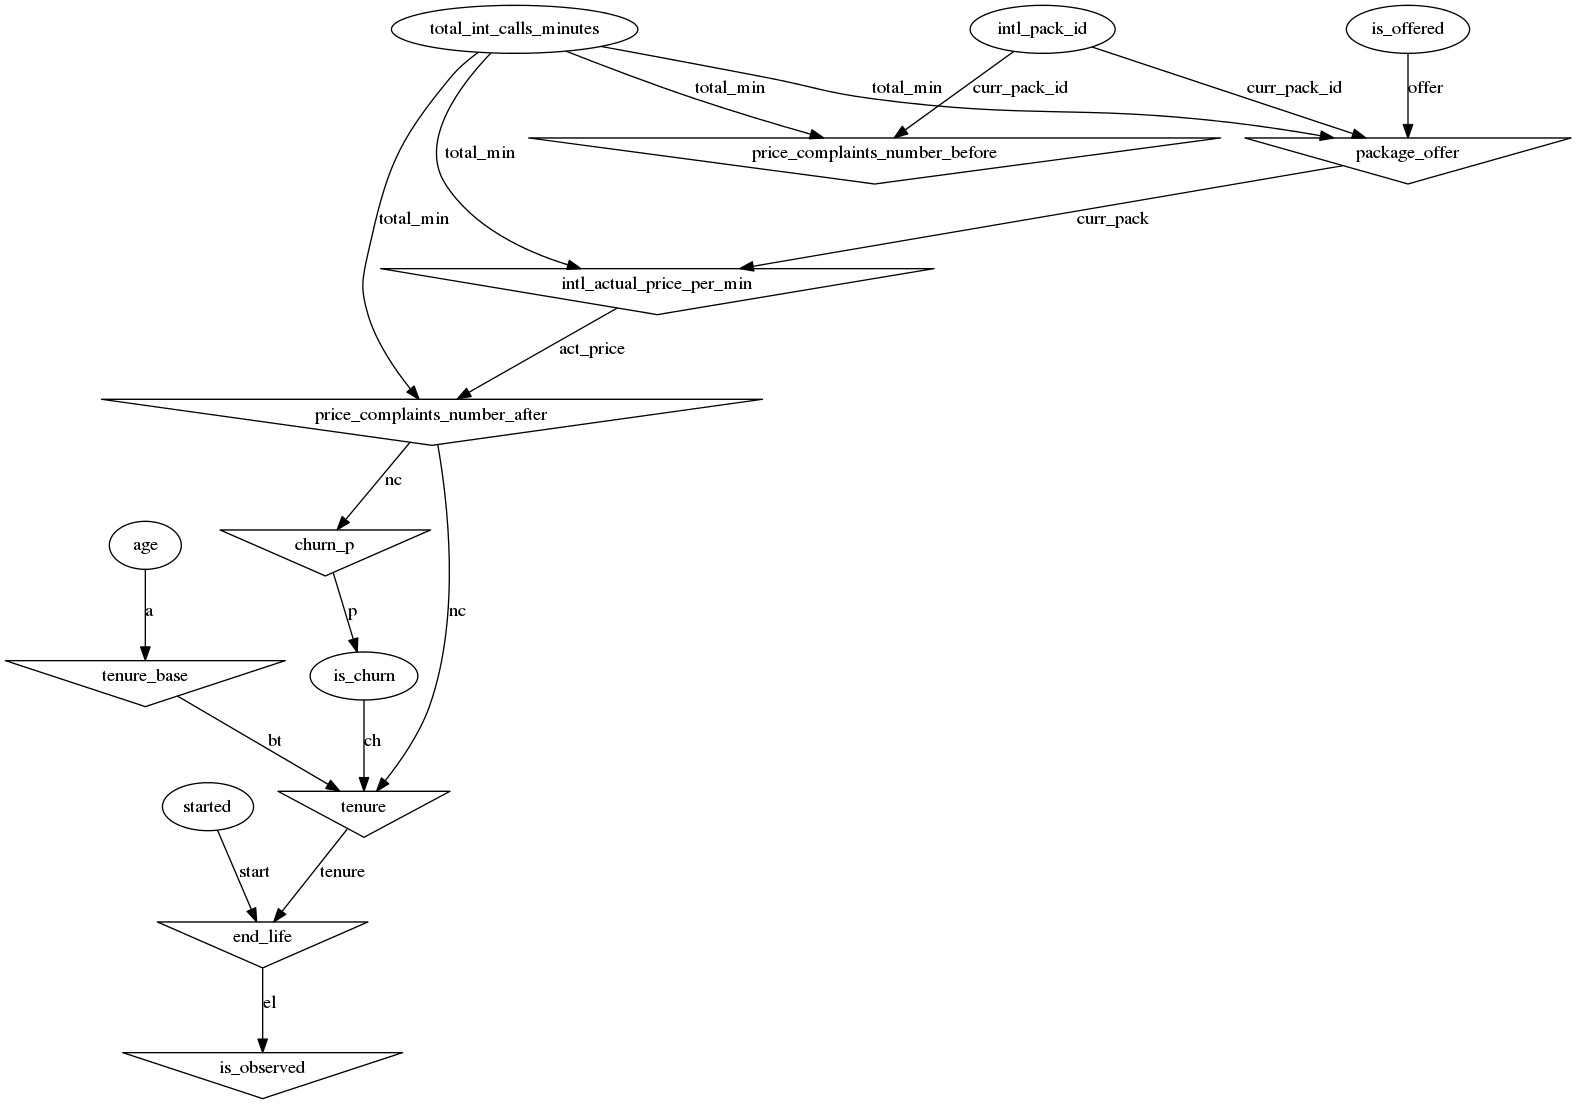

In [5]:
%matplotlib inline

xx = pymc.graph.dag(model)
xx.write_png('gendata4_graph.png', prog='dot')
Image('gendata4_graph.png')

In [6]:
init_pack = mcmc.trace('intl_pack_id')[:,0]
offered = mcmc.trace('is_offered')[:,0]
calls_minutes = mcmc.trace('total_int_calls_minutes')[:]
act_ppm = mcmc.trace('intl_actual_price_per_min')[:]
complaints_before = mcmc.trace('price_complaints_number_before')[:]
complaints_after = mcmc.trace('price_complaints_number_after')[:]
pack_offer = mcmc.trace('package_offer')[:,0]
churn_p =mcmc.trace('churn_p')[:]
churn =mcmc.trace('is_churn')[:,0]
age = mcmc.trace('age')[:,0]
tenure_base=mcmc.trace('tenure_base')[:]
tenure=mcmc.trace('tenure')[:]
started = mcmc.trace('started')[:]
end_life = mcmc.trace('end_life')[:]
observed=mcmc.trace('is_observed')[:,0]



In [7]:
len(observed), len(tenure)

(8333, 8333)


##ANALIZE GENERATED DATA

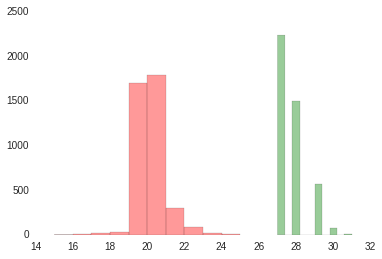

In [8]:
sns.distplot(tenure[~churn], bins=10,kde=False, color='g');
sns.distplot(tenure[churn], bins=10,kde=False, color='r');

/opt/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


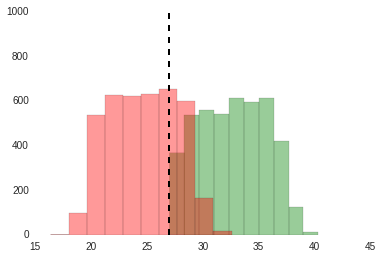

In [9]:
# sns.reset_orig()
sns.distplot(end_life[~churn], bins=10,kde=False, color='g');
sns.distplot(end_life[churn], bins=10,kde=False, color='r');
plt.vlines(observation_time,0,1000,lw=2, linestyles="--")

# sns.distplot(tenure_base,bins=10,color='b',kde=False);

# sns.reset_orig()

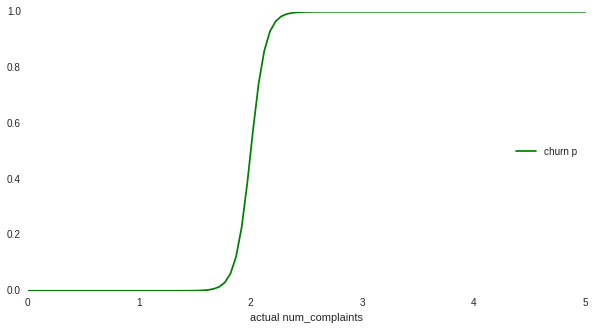

In [10]:
compalints = np.linspace(0, 5,100)
# def churn_prob(num_complaints):
#         return 1/(1+np.exp(7-3*num_complaints))
#     return 1/(1+np.exp(30-15*num_complaints))


ch_p = churn_prob(compalints)

figsize(10,5)
plt.subplot(1,1,1)
plt.plot(compalints, ch_p, 'g',label='churn p')
plt.xlabel("actual num_complaints")
plt.legend(loc='right')

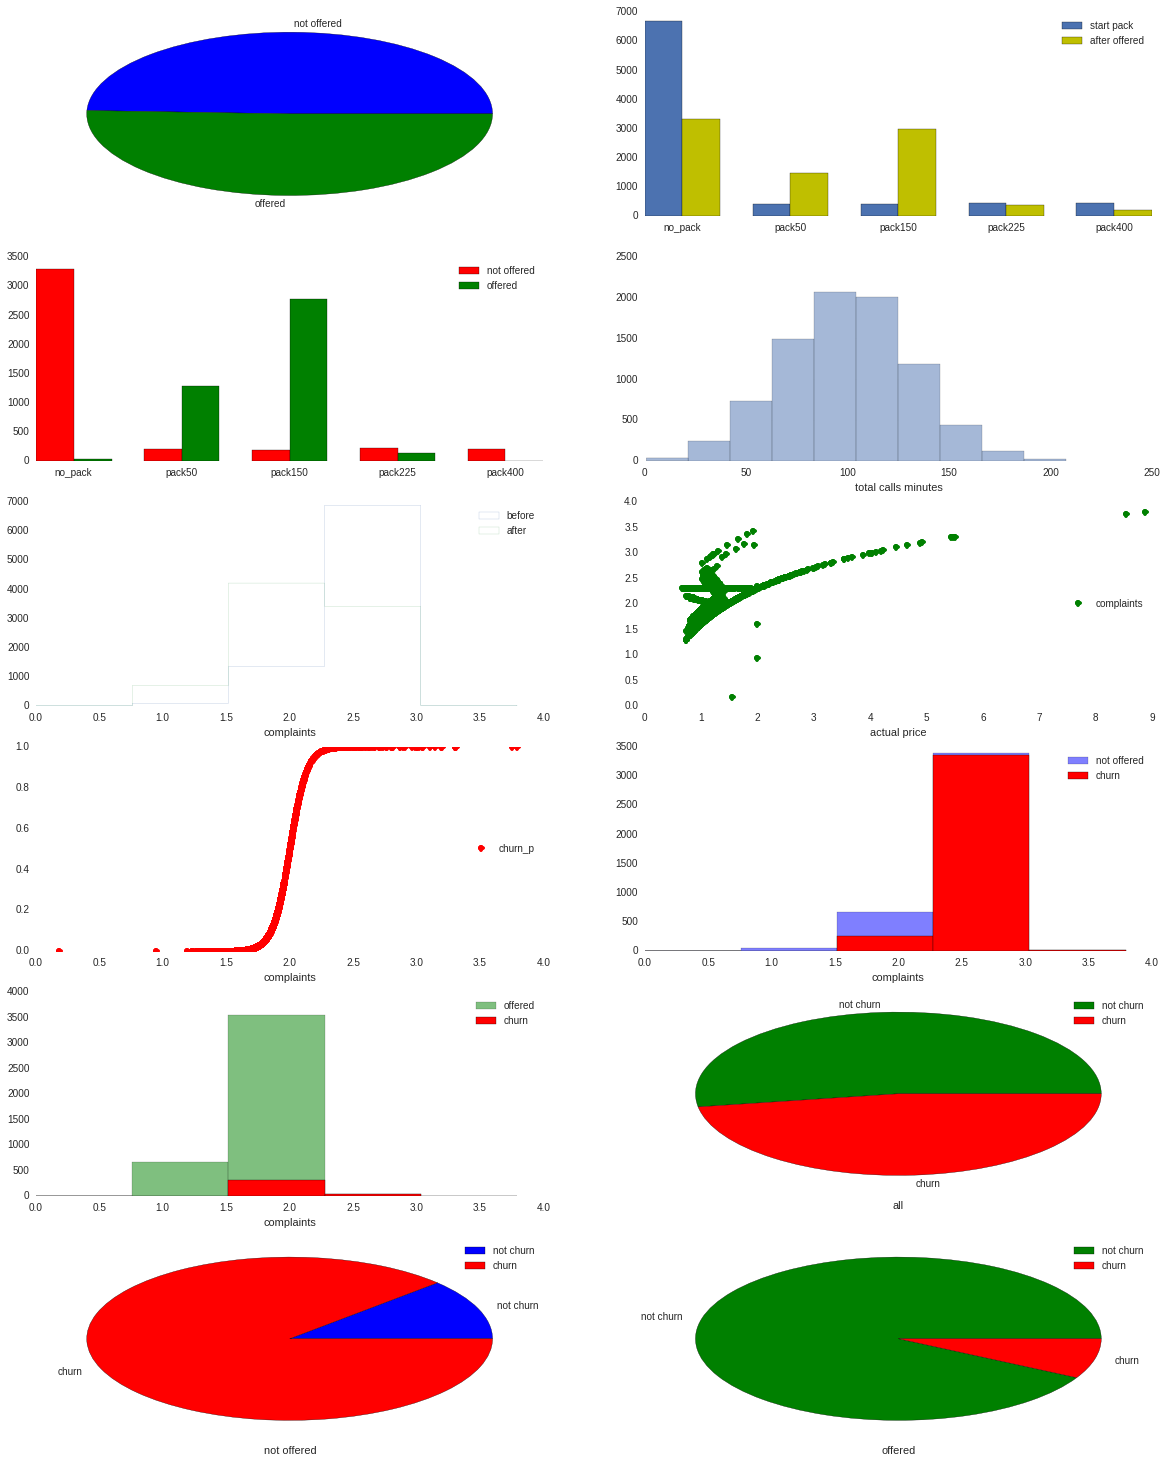

In [11]:
# {'bar', 'barstacked', 'step',  'stepfilled'}

figsize(20,30)
NN=5000
rows = 7
cols =2
i = range(1,cols*rows)
i.reverse()

complaints_bins = np.linspace(0, max(complaints_before),6)


plt.subplot(rows, cols,i.pop())
plt.pie(np.histogram(offered, bins=2)[0], labels=['not offered', 'offered'])


plt.subplot(rows,cols,i.pop())
index = np.arange(len(intl_pack_labels))
bar_width = 0.35
plt.xticks(index + bar_width, intl_pack_labels)
plt.bar(index, sp.bincount(init_pack.astype(int), minlength=5),bar_width,label='start pack')
plt.bar(index+bar_width, sp.bincount(pack_offer.astype(int), minlength=5),bar_width,label='after offered',color='y')
plt.legend(loc='upper right')


plt.subplot(rows,cols,i.pop())
index = np.arange(len(intl_pack_labels))
bar_width = 0.35
plt.xticks(index + bar_width, intl_pack_labels)
plt.bar(index, sp.bincount(pack_offer[~offered].astype(int), minlength=5),bar_width,label='not offered',color='r')
plt.bar(index+bar_width, sp.bincount(pack_offer[offered].astype(int), minlength=5),bar_width,label='offered',color='g')
plt.legend(loc='upper right')

# plt.subplot(rows,cols,i.pop())
# plt.hist(complaints_before[~offered], bins=complaints_bins, alpha=0.5, label='not offered',histtype='bar')
# plt.hist(complaints_before[offered], bins=complaints_bins, alpha=0.5, label='offered', histtype='bar')
# plt.xlabel("complaints before")
# plt.legend(loc='upper right')


plt.subplot(rows,cols,i.pop())
plt.hist(calls_minutes, bins=10, alpha=0.5, label='count',histtype='bar')
plt.xlabel('total calls minutes')


plt.subplot(rows,cols,i.pop())
plt.hist(complaints_before, bins=complaints_bins, alpha=0.5, label='before',histtype='step')
plt.hist(complaints_after, bins=complaints_bins, alpha=0.5, label='after', histtype='step')
plt.xlabel("complaints")
plt.legend(loc='upper right')


plt.subplot(rows,cols,i.pop())
plt.plot(act_ppm, complaints_before, 'og',label='complaints')
plt.xlabel("actual price")
plt.legend(loc='right')


plt.subplot(rows,cols,i.pop())
plt.plot(complaints_after, churn_p, 'or',label='churn_p')
plt.xlabel("complaints")
plt.legend(loc='right')

# plt.subplot(rows,cols,i.pop())
# plt.hist(complaints_after[~offered], bins=complaints_bins, alpha=0.5, label='not offered',histtype='bar')
# plt.hist(complaints_after[offered], bins=complaints_bins, alpha=0.5, label='offered', histtype='bar')
# plt.xlabel("complaints after")
# plt.legend(loc='upper right')



# ax1 = plt.subplot(rows,cols,i.pop())
# h1=ax1.hist(complaints_after[churn], bins=complaints_bins, alpha=0.5, label='churn', histtype='bar', color='red')
# h2=ax1.hist(complaints_after[~churn], bins=complaints_bins, alpha=0.5, label='not churn',histtype='bar')
# ax1.set_xlabel("complaints")
# ax1.legend(loc='upper right')
# ax2 = ax1.twinx()
# l1=ax2.plot(complaints_after, churn_p, '.r',label='churn_p')
# ax2.set_ylabel('churn_p')
# ax2.legend(loc='right')





plt.subplot(rows,cols,i.pop())
plt.hist(complaints_after[~offered], bins=complaints_bins, alpha=0.5, label='not offered',histtype='bar', color='b')
plt.hist(complaints_after[churn & ~offered], bins=complaints_bins, alpha=1, label='churn', histtype='bar', color='r')
plt.xlabel("complaints")
plt.legend(loc='upper right')


plt.subplot(rows,cols,i.pop())
plt.hist(complaints_after[offered], bins=complaints_bins, alpha=0.5, label='offered',histtype='bar', color='g')
plt.hist(complaints_after[churn & offered], bins=complaints_bins, alpha=1, label='churn', histtype='bar', color='red')
plt.xlabel("complaints")
plt.legend(loc='upper right')


# plt.subplot(rows,cols,i.pop())
# plt.hist(complaints_after[churn & offered], bins=1, alpha=0.2, label='churn offered', histtype='bar', color='green')
# plt.hist(complaints_after[churn & ~offered], bins=1, alpha=0.2, label='churn not offered',histtype='bar', color='blue')

plt.subplot(rows,cols,i.pop())
plt.pie(np.histogram(churn, bins=2)[0], labels=['not churn', 'churn'], colors=['g','r'])
plt.xlabel("all")
plt.legend(loc='upper right')

plt.subplot(rows,cols,i.pop())
plt.pie(np.histogram(churn[~offered], bins=2)[0], labels=['not churn', 'churn'], colors=['b','r'])
plt.xlabel("not offered")
plt.legend(loc='upper right')

plt.subplot(rows,cols,i.pop())
plt.pie(np.histogram(churn[offered], bins=2)[0], labels=['not churn', 'churn'], colors=['g','r'])
plt.xlabel("offered")
plt.legend(loc='upper right')




# plt.subplot(rows,cols,i.pop())
# plt.hist(pack_offer,50,label='after pack')
# plt.legend(loc='lower right')



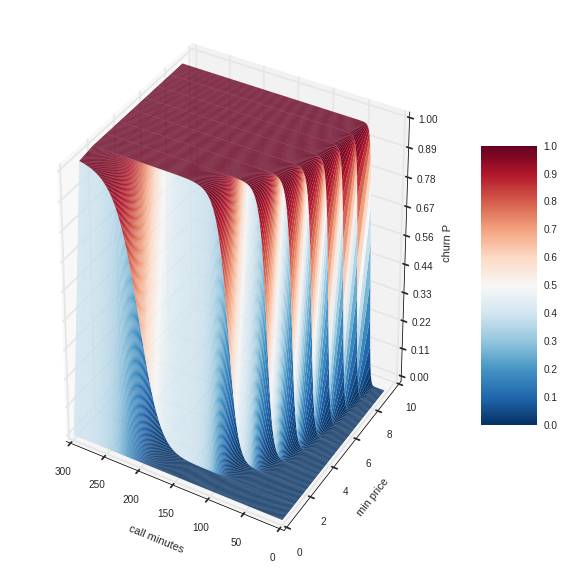

In [12]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
from numpy import exp,arange, argsort
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

def price_complaints(act_price, total_min):
#     return act_price*total_min
#     return np.log(act_price*total_min)
#     return np.maximum(0.01,np.log(act_price*total_min/20))
    return np.maximum(0.01,np.log(np.minimum(act_price*total_min/30, act_price*5)))



N = 50000
# call_minutes = pm.rhalf_normal(tau=1.0/10000, size=N)
call_minutes = arange(0,300, 1)
min_price = arange(0.01,10, 1)
X,Y = meshgrid(call_minutes, min_price) # grid of point

# points = zip(calls_minutes, act_ppm)
# sorted_points = np.sort(points)
# new_xs = [point[0] for point in sorted_points]
# new_ys = [point[1] for point in sorted_points]
# X,Y = meshgrid(new_xs[:500], new_ys[:500]) 

Z = churn_prob(price_complaints(X, Y)) # evaluation of the function on the grid

fig = plt.figure(figsize(10,10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu_r,linewidth=0, antialiased=True)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.invert_xaxis()
# ax.invert_zaxis()
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('call minutes')
ax.set_ylabel('min price')
ax.set_zlabel('churn P')

# plt.show()

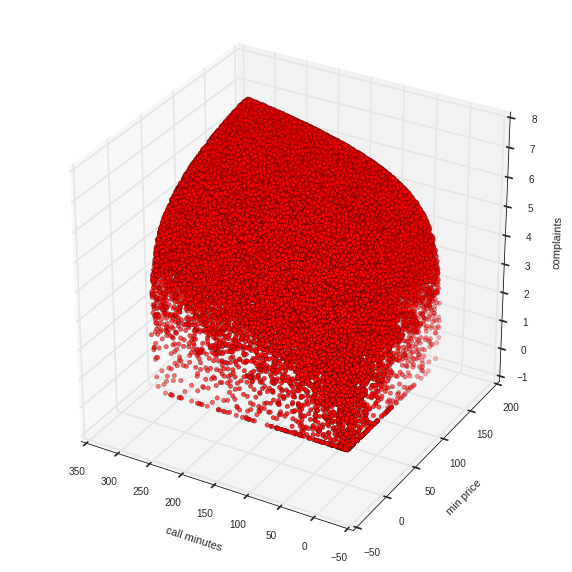

In [13]:

N = 50000
# call_minutes = pm.rhalf_normal(tau=1.0/10000, size=N)
call_minutes = pm.runiform(0,300, size=N)
min_price = pm.runiform(0.01,160, size=N)
compl = [price_complaints(m,p) for m,p in zip(call_minutes,min_price)]

fig = plt.figure(figsize(10,10))
ax = fig.add_subplot(111, projection='3d')

xs = call_minutes
ys = min_price
zs =compl


ax.scatter(xs, ys, zs, zdir=u'z', c='r', marker='o')

ax.invert_xaxis()
ax.set_xlabel('call minutes')
ax.set_ylabel('min price')
ax.set_zlabel('complaints')

plt.show()

#LEARN MODEL

In [14]:
print(__doc__)
import pandas as pd
from patsy import dmatrices
import scipy as sc
import scipy.optimize as opt
import statsmodels.api as sm

import sklearn as sk


from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import TransformerMixin
from sklearn.pipeline import BaseEstimator
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.utils.metaestimators import if_delegate_has_method
from sklearn.utils import column_or_1d
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union


from sklearn.datasets import samples_generator
from sklearn import datasets

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer

from sklearn.feature_extraction import DictVectorizer

import sklearn.feature_extraction as fe

import sklearn.feature_selection as fs
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import VarianceThreshold

import sklearn.linear_model as lm
import sklearn.grid_search as gs

import sklearn.preprocessing as preprocessing
import sklearn.cross_validation as cv
from sklearn.cross_validation import train_test_split

from sklearn_pandas import DataFrameMapper, cross_val_score

import lifelines
from lifelines import KaplanMeierFitter
from lifelines import AalenAdditiveFitter
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation

import matplotlib.pyplot as plt
import patsy
from statsmodels.sandbox import cox

from patsylearn import *


Automatically created module for IPython interactive environment


##PREPARE DATA

In [67]:
df_raw = mcmc_to_dataframe(mcmc)
df_raw.rename(columns={'package_offer': 'intl_package','price_complaints_number_after':'price_complaints_number'}, inplace=True)
# df_raw.drop(['churn_p','intl_pack_id','price_complaints_number_before','total_int_calls_minutes_dist','is_offered'], axis=1, inplace=True)
df_raw = df_raw.convert_objects(convert_numeric=True)
# df_X = pd.to_numeric(df_X, errors='coerce')

df_Y = df_raw[['tenure','is_observed','is_churn']]
df_X = df_raw[['total_int_calls_minutes','price_complaints_number','intl_package','age','tenure','is_observed']]



df_X.head()
# df_Y.head()

/opt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,total_int_calls_minutes,price_complaints_number,intl_package,age,tenure,is_observed
0,137.923465,1.470231,2,28.124691,28,False
1,106.130162,2.302585,0,30.401465,19,False
2,63.435770,1.801546,1,29.870939,28,False
3,151.728415,1.403237,2,28.406184,28,False
4,94.255988,1.850915,2,30.135349,27,False


In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y)
# Y_train, Y_test = np.ravel(Y_train).astype(float), np.ravel(Y_test).astype(float)

##TRAIN MODEL

In [17]:
X = patsy.dmatrix('total_int_calls_minutes:C(intl_package, Treatment) + age -1', data=X_train, return_type='dataframe')
# X = patsy.dmatrix('C(intl_package, Treatment) -1', data=df_X, return_type='dataframe')
# X = patsy.dmatrix('price_complaints_number+age -1', data=df_X, return_type='dataframe')

X=pd.merge(X,Y_train[['tenure','is_observed']],left_index=True, right_index=True)
# X = pd.merge(df_X[['total_int_calls_minutes']], X,left_index=True, right_index=True)
X.head()


,"total_int_calls_minutes:C(intl_package, Treatment)[0]","total_int_calls_minutes:C(intl_package, Treatment)[1]","total_int_calls_minutes:C(intl_package, Treatment)[2]","total_int_calls_minutes:C(intl_package, Treatment)[3]","total_int_calls_minutes:C(intl_package, Treatment)[4]",age,tenure,is_observed
4991,0.000000,0.000000,138.003209,0,0,32.859762,27,False
7181,67.078773,0.000000,0.000000,0,0,27.418673,20,True
1503,0.000000,0.000000,106.310519,0,0,30.147217,27,False
1064,0.000000,0.000000,90.150403,0,0,27.720017,28,False
4573,0.000000,57.908142,0.000000,0,0,32.463490,27,False


###AALEN Additive

In [18]:
aaf = AalenAdditiveFitter(coef_penalizer=1.0, fit_intercept=False)
aaf.fit(X, 'tenure', event_col='is_observed')

 [-----------------100%-----------------] 2155 of 2155 complete in 2.7 sec


<lifelines.AalenAdditiveFitter: fitted with 6249 observations, 4094 censored>

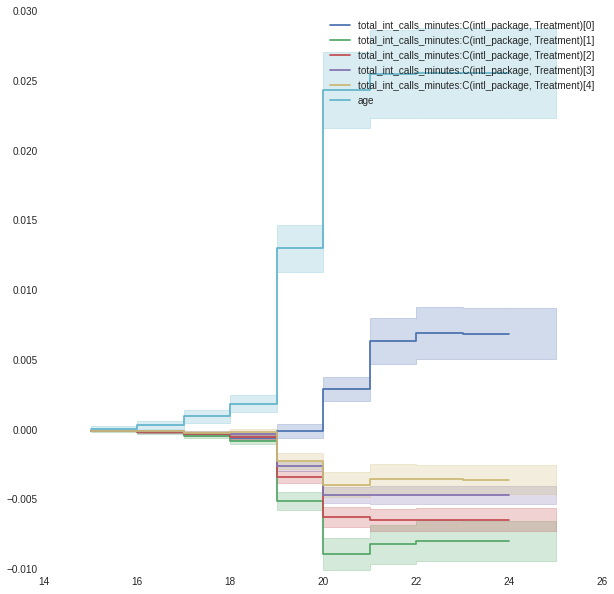

In [19]:
# aaf.plot(ix=slice(0., 100.0))
aaf.plot()

####COX PH

In [20]:
cf = CoxPHFitter()
cf.fit(X, 'tenure', event_col='is_observed')
cf.print_summary()


n=6249, number of events=2155

                                                         coef  exp(coef)  se(coef)          z          p  lower 0.95  upper 0.95     
total_int_calls_minutes:C(intl_package, Treatme...  2.003e-02  1.020e+00 3.598e-02  5.567e-01  5.777e-01  -5.051e-02   9.057e-02     
total_int_calls_minutes:C(intl_package, Treatme... -1.108e+00  3.303e-01 4.859e-02 -2.280e+01 4.657e-115  -1.203e+00  -1.013e+00  ***
total_int_calls_minutes:C(intl_package, Treatme... -2.286e+00  1.017e-01 8.016e-02 -2.852e+01 7.112e-179  -2.443e+00  -2.129e+00  ***
total_int_calls_minutes:C(intl_package, Treatme... -6.140e-01  5.412e-01 4.454e-02 -1.379e+01  3.127e-43  -7.013e-01  -5.267e-01  ***
total_int_calls_minutes:C(intl_package, Treatme... -2.431e-01  7.842e-01 2.504e-02 -9.708e+00  2.801e-22  -2.922e-01  -1.940e-01  ***
age                                                 4.602e-01  1.584e+00 2.355e-02  1.954e+01  4.937e-85   4.140e-01   5.064e-01  ***
---
Signif. codes:  0 '***' 0.0

/opt/anaconda/lib/python2.7/site-packages/lifelines/fitters/coxph_fitter.py:285: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df.sort(duration_col, inplace=True)


##MODEL VALIDATION

In [21]:
print 'CoxPHFitter'
cf = CoxPHFitter()
scores = k_fold_cross_validation(cf, X, 'tenure', event_col='is_observed', k=3)
print scores
print np.mean(scores)
print np.std(scores)
print
print 'AalenAdditiveFitter'
aaf = AalenAdditiveFitter(coef_penalizer=1.0, fit_intercept=False)
scores = k_fold_cross_validation(aaf, X, 'tenure', event_col='is_observed', k=3)
print scores
print np.mean(scores)
print np.std(scores)

CoxPHFitter
[0.8599702605375541, 0.85823431875864453, 0.84842409377353989]
0.855542891023
0.00508339316971

AalenAdditiveFitter
 [-----------------100%-----------------] 1437 of 1437 complete in 1.9 sec
 [-----------------100%-----------------] 1437 of 1437 complete in 1.2 sec
 [-----------------100%-----------------] 1436 of 1436 complete in 1.4 sec
[0.83620384684125282, 0.81275790810808324, 0.82533090955595545]
0.824764221502
0.00958014830376


/opt/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:466: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df = df.reindex(np.random.permutation(df.index)).sort(event_col)
/opt/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:471: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  testing_columns = df.columns - [duration_col, event_col]


##BUILD PIPELINE

In [61]:
class CoxPHFitterModel(BaseEstimator):
    def __init__(self, duration_column=None, event_col=None, initial_beta=None, include_likelihood=False, strata=None, alpha=0.95, tie_method='Efron', normalize=True, penalizer=0.0, **kwargs):                
        self.alpha = alpha
        self.tie_method = tie_method
        self.normalize = normalize
        self.penalizer = penalizer
        
        self.duration_column = duration_column
        self.event_col = event_col
        
        self.initial_beta = initial_beta
        self.include_likelihood = include_likelihood
        self.strata = strata

        
    def fit(self, X, y, **fit_params):
        X_ = X.copy()
        X_[self.duration_column]=y[self.duration_column]
        if self.event_col is not None:
            X_[self.event_col] = y[self.event_col]
            
        params = self.get_params()
        est = CoxPHFitter(**params)        
        
        est.fit(X_, duration_col=self.duration_column, event_col=self.event_col, initial_beta=self.initial_beta, include_likelihood=self.include_likelihood, strata=self.strata, **fit_params)
        self.estimator = est
        return self
        
    @if_delegate_has_method(delegate='estimator')
    def predict(self, X):                
        return self.estimator.predict_expectation(X)[0].values[0]
    
    def get_params(self, deep=True):   
        return {"alpha": self.alpha, "tie_method": self.tie_method, "normalize": self.normalize, "penalizer": self.penalizer}


        

In [62]:
class AalenAdditiveFitterModel(BaseEstimator):

    def __init__(self, duration_column=None, event_col=None, timeline=None, id_col=None, fit_intercept=True, alpha=0.95, coef_penalizer=0.5, smoothing_penalizer=0.0,**kwargs):        
        self.fit_intercept=fit_intercept 
        self.alpha=alpha
        self.coef_penalizer=coef_penalizer
        self.smoothing_penalizer=smoothing_penalizer
        
        self.duration_column = duration_column
        self.event_col = event_col
        self.timeline = timeline
        self.id_col = id_col

    def fit(self, X, y, **fit_params):        
        X_ = X.copy()
        X_[self.duration_column]=y[self.duration_column]
        if self.event_col is not None:
            X_[self.event_col] = y[self.event_col]
        
        params = self.get_params()        
        est = AalenAdditiveFitter(**params)        
        est.fit(X_, duration_col=self.duration_column, event_col=self.event_col, timeline=self.timeline, id_col = self.id_col, **fit_params)
        self.estimator = est
        return self
        
    @if_delegate_has_method(delegate='estimator')
    def predict(self, X):                
        return self.estimator.predict_expectation(X)[0].values[0]
    
    def get_params(self, deep=True):   
        return {"fit_intercept": self.fit_intercept, "alpha": self.alpha, "coef_penalizer": self.coef_penalizer, "smoothing_penalizer": self.smoothing_penalizer}


        

In [63]:
patsy_transf = make_pipeline(PatsyTransformer("total_int_calls_minutes:C(intl_package, Treatment) + age -1", return_type='dataframe'))

aalen_surv_ppl = make_pipeline(patsy_transf,
                         AalenAdditiveFitterModel(duration_column='tenure',event_col='is_observed',coef_penalizer=1.0, fit_intercept=False))

coxph_surv_ppl = make_pipeline(patsy_transf,
                         CoxPHFitterModel(duration_column='tenure',event_col='is_observed'))

###TRAIN MODEL

In [74]:
df_raw = mcmc_to_dataframe(mcmc)
df_raw.rename(columns={'package_offer': 'intl_package','price_complaints_number_after':'price_complaints_number'}, inplace=True)
# df_raw.drop(['churn_p','intl_pack_id','price_complaints_number_before','total_int_calls_minutes_dist','is_offered'], axis=1, inplace=True)
df_raw = df_raw.convert_objects(convert_numeric=True)
# df_X = pd.to_numeric(df_X, errors='coerce')

df_Y = df_raw[['tenure','is_observed','is_churn']]
df_X = df_raw[['total_int_calls_minutes','price_complaints_number','intl_package','age']]



df_X.head()
# df_Y.head()

/opt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,total_int_calls_minutes,price_complaints_number,intl_package,age
0,137.923465,1.470231,2,28.124691
1,106.130162,2.302585,0,30.401465
2,63.435770,1.801546,1,29.870939
3,151.728415,1.403237,2,28.406184
4,94.255988,1.850915,2,30.135349


In [75]:
X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y)

In [76]:
coxph_surv_ppl.fit(X_train, y=Y_train)

Pipeline(steps=[('pipeline', Pipeline(steps=[('patsytransformer', PatsyTransformer(NA_action='drop', add_intercept=False, eval_env=0,
         formula='total_int_calls_minutes:C(intl_package, Treatment) + age -1',
         return_type='dataframe'))])), ('coxphfittermodel', CoxPHFitterModel(alpha=0.95, normalize=True, penalizer=0.0,
         tie_method='Efron'))])

In [77]:
coxph_surv_ppl.predict(X_train[0:1])

19.669608163750556

In [78]:
X_train[0:1]

,total_int_calls_minutes,price_complaints_number,intl_package,age
8061,120.670432,2.302585,0,31.550581


##CHOOSE NEXT BEST ACTION

In [91]:
X_start = X_test.copy()
Y_start = Y_test.copy()
intl_pack_ids = map(lambda p: p[0], intl_pack_list)

pack_series = pd.Series([intl_pack_ids]*len(X_start), index=X_start.index, name='intl_pack_ids')

pack_explode = pd.concat([pd.DataFrame(v, index=np.repeat(k,len(v)), columns=['intl_pack_NBA']) for k,v in pack_series.to_dict().items()])

X = pack_explode.join(X_start)
X.rename(columns={'intl_package': 'current_intl_package','intl_pack_NBA':'intl_package'}, inplace=True)
# X.reset_index(inplace=True)
X.drop(['current_intl_package'], axis=1, inplace=True)
# X.intl_package = X.intl_package.astype(str)
X.head()

,intl_package,total_int_calls_minutes,price_complaints_number,age
4,0,94.255988,1.850915,30.135349
4,1,94.255988,1.850915,30.135349
4,2,94.255988,1.850915,30.135349
4,3,94.255988,1.850915,30.135349
4,4,94.255988,1.850915,30.135349


In [87]:
coxph_surv_ppl.predict(X[0:1]) 

20.455941909630031

In [93]:
def predict(row):    
    dr = pd.DataFrame(row).T    
    expected = coxph_surv_ppl.predict(dr)   
    return expected

X['expected'] = X.apply(predict, axis=1)
X_nba = X.sort_values('expected', ascending=False).groupby(level=0).first()

X_nba.head()

,intl_package,total_int_calls_minutes,price_complaints_number,age,expected
4,2,94.255988,1.850915,30.135349,30.581572
6,2,106.655922,2.302585,27.934962,30.844244
8,2,70.252801,1.862749,32.044918,29.336524
17,2,24.865395,2.302585,30.162814,24.954414
26,2,109.684361,1.699323,27.833271,30.866080


In [94]:
X_start['expected'] = X_start.apply(predict, axis=1)
X_start.head()

,total_int_calls_minutes,price_complaints_number,intl_package,age,expected
6427,124.714881,2.302585,0,25.944017,23.838476
2791,96.838281,2.302585,0,30.260451,20.373100
5020,148.413075,1.396930,2,28.047078,30.973465
2215,134.743093,1.493560,2,32.458242,30.878907
308,98.391554,2.302585,0,27.426213,22.567676


In [95]:
sum(X_nba.expected), sum(X_start.expected), sum(Y_start.tenure)

(63103.894184239209, 55415.862425377272, 50126)

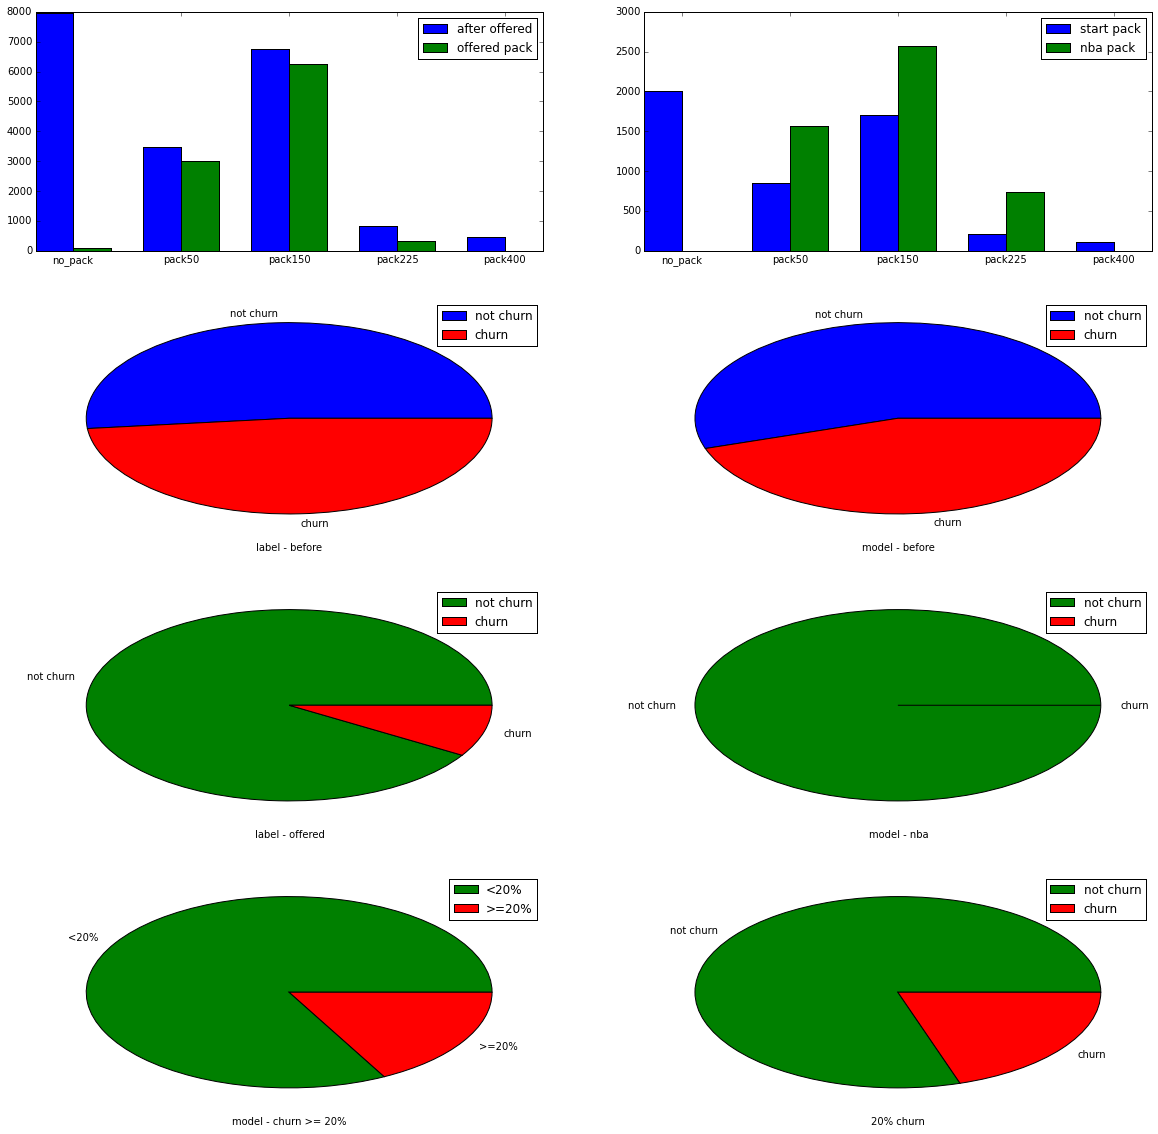

In [58]:
# {'bar', 'barstacked', 'step',  'stepfilled'}
figsize(20,30)
NN=5000
rows = 6
cols =2
i = range(1,cols*rows)
i.reverse()

plt.subplot(rows,cols,i.pop())
index = np.arange(len(intl_pack_labels))
bar_width = 0.35
plt.xticks(index + bar_width, intl_pack_labels)
# plt.bar(index, sp.bincount(init_pack.astype(int), minlength=5),bar_width,label='start pack')
plt.bar(index, sp.bincount(pack_offer.astype(int), minlength=5),bar_width,label='after offered',color='b')
plt.bar(index+bar_width, sp.bincount(pack_offer[offered].astype(int), minlength=5),bar_width,label='offered pack',color='g')
plt.legend(loc='upper right')

plt.subplot(rows,cols,i.pop())
index = np.arange(len(intl_pack_labels))
bar_width = 0.35
plt.xticks(index + bar_width, intl_pack_labels)
plt.bar(index, sp.bincount(X_start.intl_package.astype(int), minlength=5),bar_width,label='start pack')
plt.bar(index+bar_width, sp.bincount(X_nba.intl_package.astype(int), minlength=5),bar_width,label='nba pack',color='g')
plt.legend(loc='upper right')


# plt.subplot(rows,cols,i.pop())
# plt.pie(np.histogram(churn, bins=2)[0], labels=['not churn', 'churn'], colors=['g','r'])
# plt.xlabel("all")
# plt.legend(loc='upper right')


plt.subplot(rows,cols,i.pop())
plt.pie(sp.bincount(Y_test.astype(int), minlength=2), labels=['not churn', 'churn'], colors=['b','r'])
plt.xlabel("label - before")
plt.legend(loc='upper right')

plt.subplot(rows,cols,i.pop())
plt.pie(sp.bincount(X_start.is_churn.astype(int), minlength=2), labels=['not churn', 'churn'], colors=['b','r'])
plt.xlabel("model - before")
plt.legend(loc='upper right')

plt.subplot(rows,cols,i.pop())
plt.pie(np.histogram(churn[offered], bins=2)[0], labels=['not churn', 'churn'], colors=['g','r'])
plt.xlabel("label - offered")
plt.legend(loc='upper right')


plt.subplot(rows,cols,i.pop())
plt.pie(sp.bincount(X_nba.is_churn.astype(int), minlength=2), labels=['not churn', 'churn'], colors=['g','r'])
plt.xlabel("model - nba")
plt.legend(loc='upper right')

plt.subplot(rows,cols,i.pop())
plt.pie([X_nba[X_nba['churn_p']<0.2].is_churn.count(),X_nba[X_nba['churn_p']>=0.2].is_churn.count()], labels=['<20%', '>=20%'], colors=['g','r'])
plt.xlabel("model - churn >= 20%")
plt.legend(loc='upper right')


plt.subplot(rows,cols,i.pop())
float(X_nba[X_nba['churn_p']>0.2].is_churn.count())/X_nba.is_churn.count()
plt.pie(sp.bincount(pm.rbernoulli(0.2, len(X_nba)), minlength=2), labels=['not churn', 'churn'], colors=['g','r'])
plt.xlabel("20% churn")
plt.legend(loc='upper right')


# plt.subplot(rows,cols,i.pop())
# plt.hist(pack_offer,50,label='after pack')
# plt.legend(loc='lower right')



0.1723076923076923

In [79]:
sp.bincount(X_nba.is_churn.astype(int))

array([4875])

##CHOOSE HYPER PARAMETERS 

In [21]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']


In [22]:
scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5,
                       scoring='%s_weighted' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision
()


NameError: name 'GridSearchCV' is not defined

##OTHER

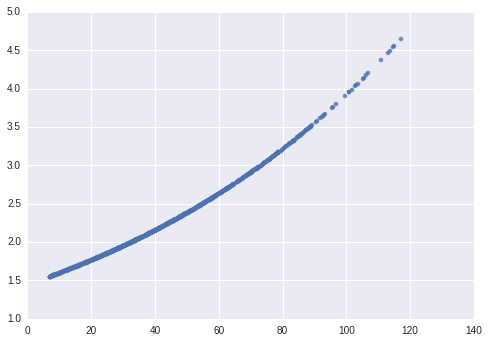

In [115]:
N=1000
age = pm.rtruncated_normal(mu=30,tau=(1./30**2), a=7, b=120, size=N)

c = 2

def tenure_by_age(age):
    return np.exp(age/100)/np.log(c)
    if (age < 30):
        return 2.1+5/np.exp(age/10)
    elif age > 50:
        return np.exp(age/60)
    else:
        return 2.3
    


tenure = np.array(map(tenure_by_age, age))
sns.regplot(age, tenure, fit_reg=False)


hazard = pm.Logistic


In [ ]:
N=1000
age = pm.rtruncated_normal(mu=30,tau=(1./30**2), a=7, b=120, size=N)
sp

In [ ]:
compalints = np.linspace(0, 5,100)
def churn_prob(num_complaints):
    return 1/(1+np.exp(30-15*num_complaints))

ch_p = churn_prob(compalints)

figsize(10,5)
plt.subplot(1,1,1)
plt.plot(compalints, ch_p, 'g',label='churn p')
plt.xlabel("actual price")
plt.legend(loc='right')

In [ ]:
class CategorizeColumns_Transformer(TransformerMixin):

    def __init__(self, columns, **kwargs):
        self.columns = columns       

    def transform(self, X, **transform_params):          
        df_cat_raw = X[self.columns]
        cat_dict = df_cat_raw.T.to_dict().values()
        dvec = DictVectorizer(sparse=False)
        dvec.fit_transform(cat_dict)
        df_cat = pd.DataFrame(cat_vec, columns=dvec.feature_names_)
        return df_cat        

    def fit(self, X, y=None, **fit_params):
        return self

In [ ]:
labels = [1, 1, 1, 2, 2, 2, 3, 3, 3, 3]
kf = cv.KFold(10, n_folds=3)
for train, test in kf:
    print("%s %s" % (train, test))
print 
skf = cv.StratifiedKFold(labels, n_folds=3)
for train, test in kf:
    print("%s %s" % (train, test))

In [ ]:
df_X

In [ ]:
df_X = poly.fit_transform(df_X_copy)


In [ ]:
X_test[0]

In [ ]:
class MCMC_to_DF_Transformer(TransformerMixin):

    def __init__(self, rename_columns={}, drop_columns=[], **kwargs):
        self.rename_columns = rename_columns
        self.drop_columns = drop_columns
        
    def mcmc_to_dataframe(self, mcmc):
        df1 = pd.DataFrame(data=[s.trace.gettrace() if len(s.trace.gettrace().shape)==1 else s.trace.gettrace()[:,0] for s in mcmc.variables])
        df2 = df1.T
        df2.columns = [s.trace.name for s in mcmc.variables]
        return df2

    def transform(self, X, **transform_params):          
        df_raw = self.mcmc_to_dataframe(X)
        df_raw.rename(columns=rename_columns, inplace=True)
        df_raw.drop(drop_columns, axis=1, inplace=True)
        return df_raw

    def fit(self, X, y=None, **fit_params):
        return self

In [ ]:
print sc.stats.stats.pearsonr(X_test, Y_test)
# print np.corrcoef(X_test[:,0], Y_test)

In [ ]:
#PREPARE CATEGORICAL FEATURES
cat_dict = df_cat_raw.T.to_dict().values()
dvec = DictVectorizer(sparse=False)
cat_vec = dvec.fit_transform(cat_dict)
df_cat = pd.DataFrame(cat_vec, columns=dvec.feature_names_)



In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_train.shape

# X_train = SelectKBest(chi2, k=2).fit_transform(X_train, Y_train)
X_train.shape
X_train

In [ ]:
plt.figure(figsize=(100, 20));
vstack = np.vstack((np.ravel(df_Y_test.is_churn.astype(float))[0:50], y_predicted.astype(float)[0:50]))
plt.imshow(vstack, interpolation='none', cmap='bone');
# plt.imshow(np.vstack(([1,0,1,0], [1,0,1,1])), interpolation='none', cmap='bone');
plt.xticks([]); plt.yticks([]);
plt.title(("Actual and predicted survival outcomes on the test set"));

In [ ]:
enc = preprocessing.OneHotEncoder(n_values=len(intl_pack_ids))
# enc.fit(df_raw.package_offer.values.astype(int))
print enc.transform([df_raw.package_offer.values.astype(int)])